In [1]:
using Distributed
addprocs(8);

In [2]:
@everywhere using PulseInputDDM

In [3]:
ncells = [3,3];

In [4]:
ntrials = [100,100];

In [5]:
#f = [["Softplus" for n in 1:N] for N in ncells]
    f = all_Softplus(ncells)

2-element Vector{Vector{String}}:
 ["Softplus", "Softplus", "Softplus"]
 ["Softplus", "Softplus", "Softplus"]

In [6]:
θ_generative = θneural_choice(θz=θz(σ2_i = 5., B = 15., λ = -0.5, σ2_a = 100., σ2_s = 0.5,
    ϕ = 0.4, τ_ϕ = 0.02), bias=1.0, lapse=0.05, θy=[[Softplus(rand([-2., 2.])) for n in 1:N] for N in ncells], 
    f = f);

In [7]:
data, μ_rnt, μ_t = synthetic_data(θ_generative, ntrials, ncells; centered=true, pos_ramp=true, dt_synthetic=1e-4,
    rng=3);

In [8]:
output = PulseInputDDM.process_spike_data.(μ_rnt, data; nconds=2);

In [9]:
μ_ct = getindex.(output, 1)
σ_ct = getindex.(output, 2);

In [10]:
fitbool, lb, ub = neural_choice_options(f)
ub[2] = 40.

40.0

In [11]:
model = neural_choiceDDM(θ=θ_generative, fit=fitbool, lb=lb, ub=ub)  

neural_choiceDDM{θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}}
  θ: θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}
  n: Int64 53
  cross: Bool false
  fit: Array{Bool}((15,)) Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  ub: Array{Float64}((15,)) [100.0, 40.0, 5.0, 400.0, 10.0, 1.2, 1.0, 10.0, 1.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
  lb: Array{Float64}((15,)) [0.001, 8.0, -5.0, 0.001, 0.001, 0.001, 0.005, -10.0, 0.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0]


In [12]:
_, μ_c_λ, = simulate_expected_firing_rate(model, data; num_samples=100, nconds=2);

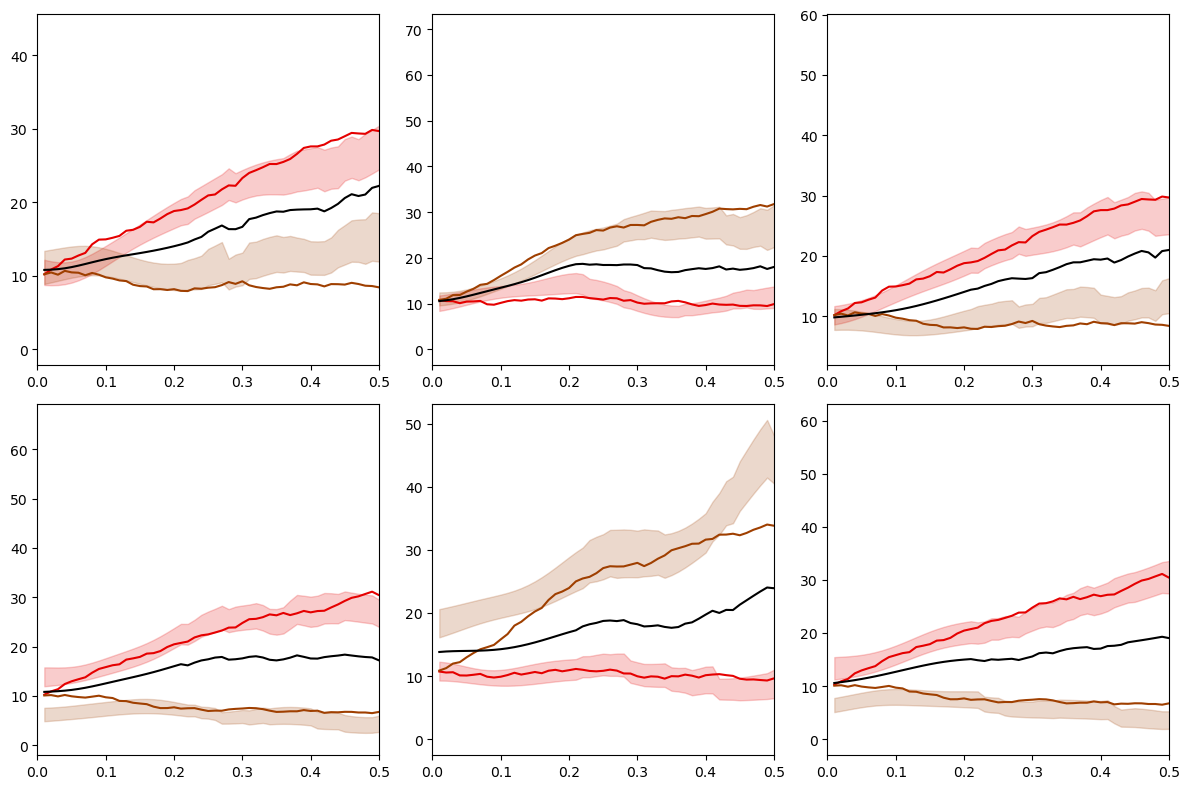

In [13]:
using PyPlot

dt = 1e-2

num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]

for i in 1:num_rows
        
    for j in 1:data[i][1].ncells             
        for k = 1:2     

            ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                μ_ct[i][j][k] + σ_ct[i][j][k],
                μ_ct[i][j][k] - σ_ct[i][j][k],
                alpha=0.2, color=my_colors[k])

            ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                μ_c_λ[i][j][k], color=my_colors[k])                                     

            ax[i,j].set_xlim((0, 0.5))
                        
        end   
        
        ax[i,j].plot((1:length(μ_t[i][j]))*dt,
            μ_t[i][j], color="black")

    end
    
end

tight_layout()
display(gcf())

In [14]:
using Flatten

In [15]:
joint_loglikelihood(model, data)

-15597.169902647052

In [16]:
x0 = vcat([0.1, 20., -0.1, 20., 0.8, 0.01, 0.008], 
    [0., 1e-1], vcat(θy.(data, f)...)...);

In [17]:
model.θ = θneural_choice(x0, f)

θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}
  θz: θz{Float64}
  bias: Float64 0.0
  lapse: Float64 0.1
  θy: Array{Vector{Softplus{Float64}}}((2,))
  f: Array{Vector{String}}((2,))


In [18]:
joint_loglikelihood(model, data)

-16174.452898960319

In [19]:
model, = choice_neural_optimize(model, data; iterations=1, outer_iterations=1, f_tol=1e-12, x_tol=1e-12)

Fminbox
-------
Initial mu = 0.0265679

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.0265679

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.617335e+04     1.086742e+04
 * time: 0.006989955902099609

Exiting inner optimizer with x = [0.10000357896968144, 20.0000046764897, -0.09997686845768916, 20.00000093549536, 0.8000287170689762, 0.010019591385664375, 0.005409005663209128, 1.5341518463820386e-7, 0.09999855263462876, -0.5022720749742033, 0.5572810856016226, -0.5320255402472784, -0.7167758932970411, 0.769660754840789, -0.7166738421758613]
Current distance to box: 0.000409006
Decreasing barrier term μ.



(neural_choiceDDM{θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}}
  θ: θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}
  n: Int64 53
  cross: Bool false
  fit: Array{Bool}((15,)) Bool[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  ub: Array{Float64}((15,)) [100.0, 40.0, 5.0, 400.0, 10.0, 1.2, 1.0, 10.0, 1.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
  lb: Array{Float64}((15,)) [0.001, 8.0, -5.0, 0.001, 0.001, 0.001, 0.005, -10.0, 0.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0]
,  * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.614722e+04

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 2.59e-03 ≰ 1.0e-12
    |x - x'|/|x'|          = 9.15e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 1.0e-12
    |g(x)|                 = 1.99e+01 ≰ 1.0e-03

 * Work counters
    Seconds ru

In [20]:
hcat(collect(PulseInputDDM.flatten(model.θ)), collect(PulseInputDDM.flatten(θ_generative)))

15×2 Matrix{Float64}:
  0.100004      5.0
 20.0          15.0
 -0.0999769    -0.5
 20.0         100.0
  0.800029      0.5
  0.0100196     0.4
  0.00540901    0.02
  1.53415e-7    1.0
  0.0999986     0.05
 -0.502272     -2.0
  0.557281      2.0
 -0.532026     -2.0
 -0.716776     -2.0
  0.769661      2.0
 -0.716674     -2.0

In [21]:
_, μ_c_λ, = simulate_expected_firing_rate(model, data; num_samples=100, nconds=2);

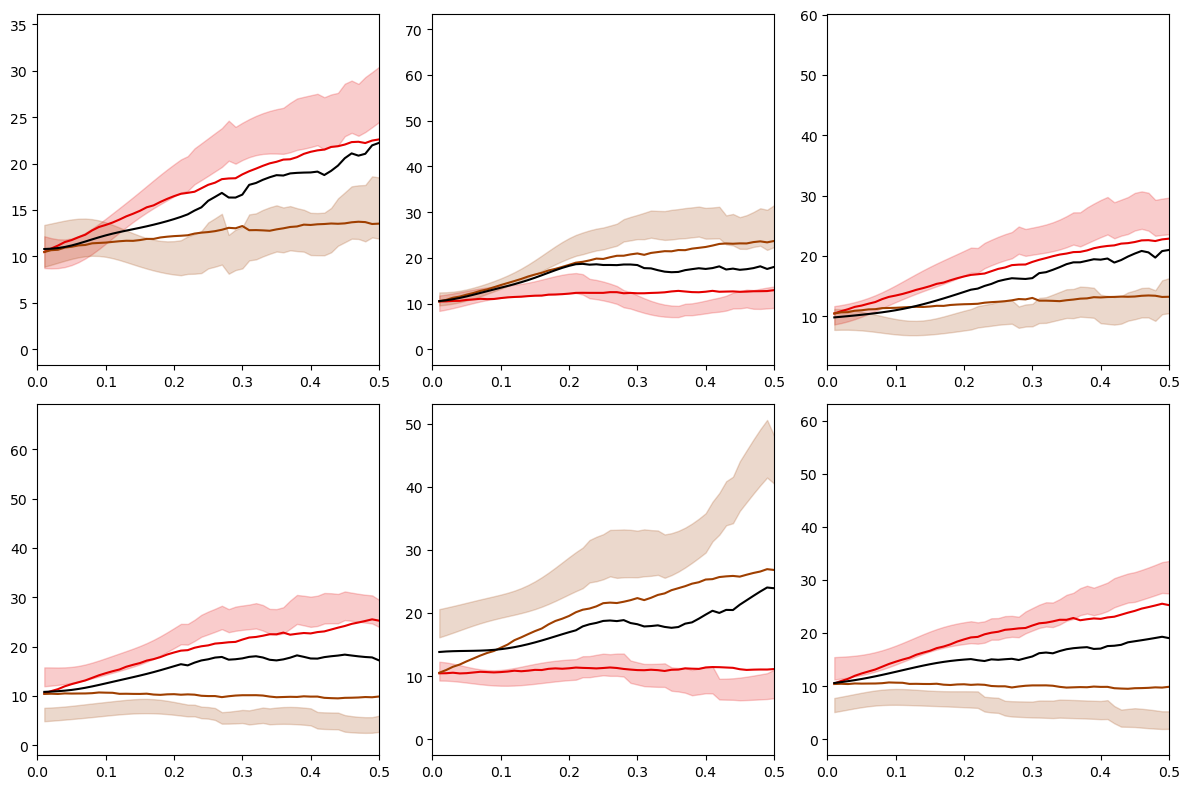

In [22]:
num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]

for i in 1:num_rows
        
    for j in 1:data[i][1].ncells             
        for k = 1:2     

            ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                μ_ct[i][j][k] + σ_ct[i][j][k],
                μ_ct[i][j][k] - σ_ct[i][j][k],
                alpha=0.2, color=my_colors[k])

            ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                μ_c_λ[i][j][k], color=my_colors[k])                                     

            ax[i,j].set_xlim((0, 0.5))
                        
        end   
        
        ax[i,j].plot((1:length(μ_t[i][j]))*dt,
            μ_t[i][j], color="black")

    end
    
end

tight_layout()
display(gcf())

In [23]:
H = Hessian(model, data)

15×15 Matrix{Float64}:
   67.7822        -0.811481       -1.68519    …     -1.62335       1.49082
   -0.811481       3.27769        -6.27209           3.06939      -1.16851
   -1.68519       -6.27209        28.4409           10.3613      -11.331
    0.164127      -0.212396        0.559686         -0.162352      0.173107
    7.42009      -10.741          24.0656           -9.02804       7.22867
    1.9767        -5.87094        23.5874     …     11.954       -18.9258
 -383.15        1097.72        -4409.89          -1982.79       3458.69
   -0.00549753    -0.00974035     -0.0128321         0.0620229    -0.257666
    1.68489        0.629189        0.712631          1.41249     -17.5472
    3.49967        2.72513         8.31631          -0.0          -0.0
   -1.64336       -1.24536         1.91558    …     -0.0          -0.0
    3.2879         3.36205         8.66759          -0.0          -0.0
    0.789067      -2.66876        -9.79839          19.4316      -38.0081
   -1.62335        3

In [24]:
using LinearAlgebra

In [25]:
eigvals(H)

15-element Vector{Float64}:
 -142.76278742757344
    0.04824640885150478
    0.829501751347784
    1.1069156229341541
   16.4531193053681
   67.44113796679659
  131.01255557104835
  220.71047230788545
  284.46309431593914
  335.3310764351802
  413.1924164731658
  480.31674196693336
  542.690334309298
  666.929877067623
    1.363996291582135e6

In [26]:
choice_inputs = map(x-> PulseInputDDM.choiceinputs(clicks=x.clicks, binned_clicks=x.binned_clicks, 
    dt=1e-2, centered=false), getfield.(vcat(data...), :input_data));
choice_data = PulseInputDDM.choicedata.(choice_inputs, getfield.(vcat(data...), :choice));
choices = getfield.(choice_data, :choice);

In [27]:
x = PulseInputDDM.flatten(model.θ);

In [28]:
syn_choices = rand.(Ref(Flatten.reconstruct(θchoice(), x[1:9])), choice_inputs, 1:length(choice_inputs));

In [29]:
output = map(x-> binLR(x.click_data.binned_clicks, x.click_data.clicks, x.click_data.dt), choice_data);
L,R = getindex.(output,1), getindex.(output,2);
ΔLR = last.(cumsum.(-L .+ R));

In [30]:
using Optim, LineSearches, ForwardDiff, Distributions
w0 = [0.1, 1., 0.];

In [31]:
mylogit(w) = (w[1]/2 .+ (1 .- w[1]) ./ (1. .+ exp.(-w[2]*ΔLR .+ w[3])));
ll(w) = -1 * sum(logpdf.(Bernoulli.(vec(mylogit(w))), choices))
obj = OnceDifferentiable(ll, w0; autodiff=:forward)
m = BFGS(alphaguess = InitialStatic(alpha=1.0,scaled=true), linesearch = BackTracking());
output = Optim.optimize(obj, [0, -Inf, -Inf], [1., Inf, Inf], w0, Fminbox(m));
what_data = Optim.minimizer(output);

In [32]:
xs = sort(ΔLR);
idxs = sortperm(ΔLR)
y_data = mylogit(what_data)[idxs];

In [33]:
ll(w) = -1 * sum(logpdf.(Bernoulli.(vec(mylogit(w))), syn_choices))
obj = OnceDifferentiable(ll, w0; autodiff=:forward)
output = Optim.optimize(obj, [0, -Inf, -Inf], [1., Inf, Inf], w0, Fminbox(m));
what_syn = Optim.minimizer(output);

In [34]:
y_syn = mylogit(what_syn)[idxs];

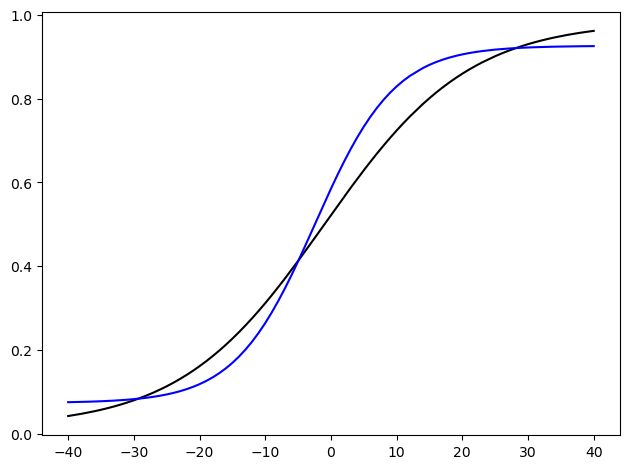

In [35]:
fig, ax = subplots(1, 1)
ax.plot(xs, y_data, label="data", color="black", linestyle="-")
ax.plot(xs, y_syn, label="syn", color="blue", linestyle="-")
tight_layout()
display(gcf())

In [36]:
x = 1

1